# Fig: mean degree and degree heterogeneity
ISHII Hidemasa

In [1]:
using Graphs, Statistics, DataFramesMeta
using CairoMakie
import ColorSchemes as cs

In [2]:
### new format for axes tick labels on log10 scale ###
digits_super = collect("⁰¹²³⁴⁵⁶⁷⁸⁹")
digits_sub = collect("₀₁₂₃₄₅₆₇₈₉")

function superscript(n::Integer; dsup=digits_super, dsub=digits_sub)
    if_pos = n >= 0
    if if_pos
        return join(dsup[begin .+ reverse(digits(n))])
    else
        return "⁻" * join(dsup[begin .+ reverse(digits(-n))])
    end
end

function log10format(value; digits=2, minabsexp=3)
    exponent = floor(Integer, log10(value))

    if abs(exponent) < minabsexp
        # no formatting for small value
        return "$(round(value, digits=max(1 - exponent, 1)))" 
    end

    coeff = round(value / 10.0^exponent, RoundNearestTiesUp; digits=digits)
    if coeff == 1
        return "10$(superscript(exponent))"
    else
        return "$(coeff)×10$(superscript(exponent))"
    end
end

log10format (generic function with 1 method)

In [3]:
include("nwparams.jl");

In [4]:
degree2κ(degree) = mean(degree.^2) / mean(degree)^2

degree2κ (generic function with 1 method)

In [5]:
v_nwfunc = [
    cbg256, cbg512, ssf256, ssf512, 
    er256, er512, rrg256, rrg512
    #ba256, ba512, 
]
v_nwmodel = ["cbg", "ssf", "er", "rrg"]  #"ba"

4-element Vector{String}:
 "cbg"
 "ssf"
 "er"
 "rrg"

In [6]:
data = DataFrame(
    id=String[], N=Int64[], meandegree=Float64[], κ_N=Float64[]
)

Row,id,N,meandegree,κ_N
,String,Int64,Float64,Float64


In [7]:
for nwfunc in v_nwfunc
    df_p, nwgen = nwfunc()
    for prow in eachrow(df_p)
        nw = nwgen(prow)
        push!(data, (
            id=prow.id, N=nv(nw), meandegree=mean(degree(nw)),
            κ_N=degree2κ(degree(nw)) / nv(nw)
        ))
    end
end

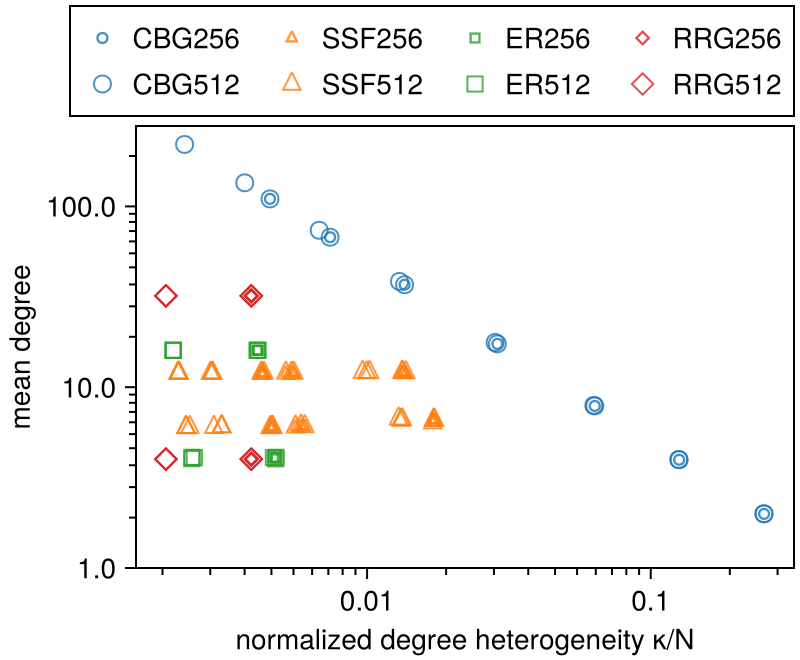

In [8]:
let plt=cs.tab10, ifsave=true
    fig = Figure(size=(400, 330), figure_padding=3)
    ax = Axis(fig[1, 1], ylabel="mean degree", 
        xlabel="normalized degree heterogeneity κ/N",
        xgridvisible=false, ygridvisible=false,
        xscale=log10, yscale=log10,
        xtickformat=vals -> log10format.(vals, digits=2),
        ytickformat=vals -> log10format.(vals, digits=2),
        xticks=(10.0).^(-5:5), yticks=(10.0).^(-5:5),
        xminorticksvisible=true, xminorticks=IntervalsBetween(10),
        yminorticksvisible=true, yminorticks=IntervalsBetween(10),
        alignmode=Outside(),
    )
    ylims!(ax, low=1)
    d_color = Dict(
        :cbg=>cs.tab10[1], :ssf=>cs.tab10[2],
        :er=>cs.tab10[3], :rrg=>cs.tab10[4],
    )
    d_marker = Dict(
        :cbg=>:circle, :ssf=>:utriangle, :ba=>:dtriangle,
        :er=>:rect, :rrg=>:diamond
    )
    style256 = (markersize=7, strokewidth=1.2,)
    style512 = (markersize=12, strokewidth=1,)
    for (j, model) in enumerate(v_nwmodel)
        subdata = @subset(data, occursin.(model, :id))
        sd256 = @subset(subdata, occursin.("256", :id))
        sd512 = @subset(subdata, occursin.("512", :id))
        scatopts = (
            marker=d_marker[Symbol(model)], 
            color=(:black, 0), strokecolor=(plt[j], 0.8),
        )
        scatter!(ax, sd256.κ_N, sd256.meandegree; 
            label=uppercase(model) * "256",
            style256..., scatopts...
        )
        scatter!(ax, subdata.κ_N, subdata.meandegree; 
            label=uppercase(model) * "512",
            style512..., scatopts...
        )
    end
    Legend(fig[0, 1], ax;
        orientation=:horizontal, nbanks=2, halign=:right,
    )
    rowgap!(fig.layout, 5)
    if ifsave save("output/fig-meandeg-deghet.pdf", fig) end
    display(fig)
end;